# CLAHE

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [1]:
%cd /tf/notebooks

/tf/notebooks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from preprocessing import apply_clahe


import cv2
from deepface import DeepFace


In [4]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = preprocessing(path)
        img = resize(img,shape)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

## Example

In [5]:
indian_img_path = pd.read_pickle("results/arcface/African/result_dict1.pickle")["data"][340:341].original_image.values[0]

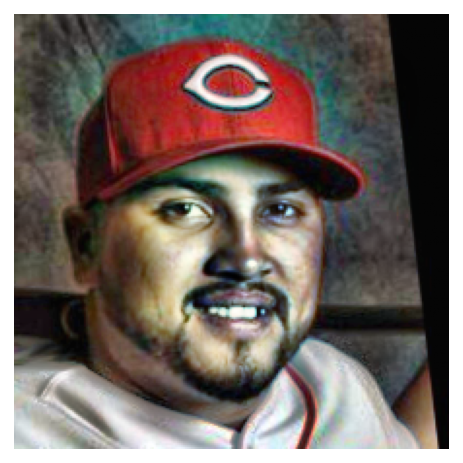

In [6]:
#indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = apply_clahe)
plt.imshow(indian_img)
plt.axis('off');

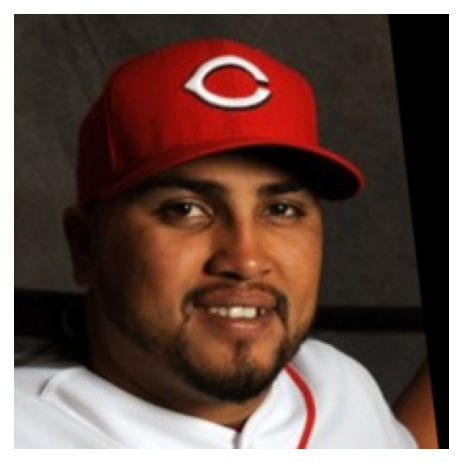

In [7]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img)
plt.axis('off');

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [8]:
facenet_model = "facenet_clahe"

In [9]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.941486,0.940538,0.942433
0,Asian,0.915705,0.914612,0.916799
0,Caucasian,0.892436,0.891251,0.893621
0,African,0.887936,0.886684,0.889189


In [10]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.877487,0.876319,0.878654
0,Asian,0.851410,0.850074,0.852746
0,African,0.834043,0.832732,0.835355
0,Caucasian,0.789497,0.788122,0.790871


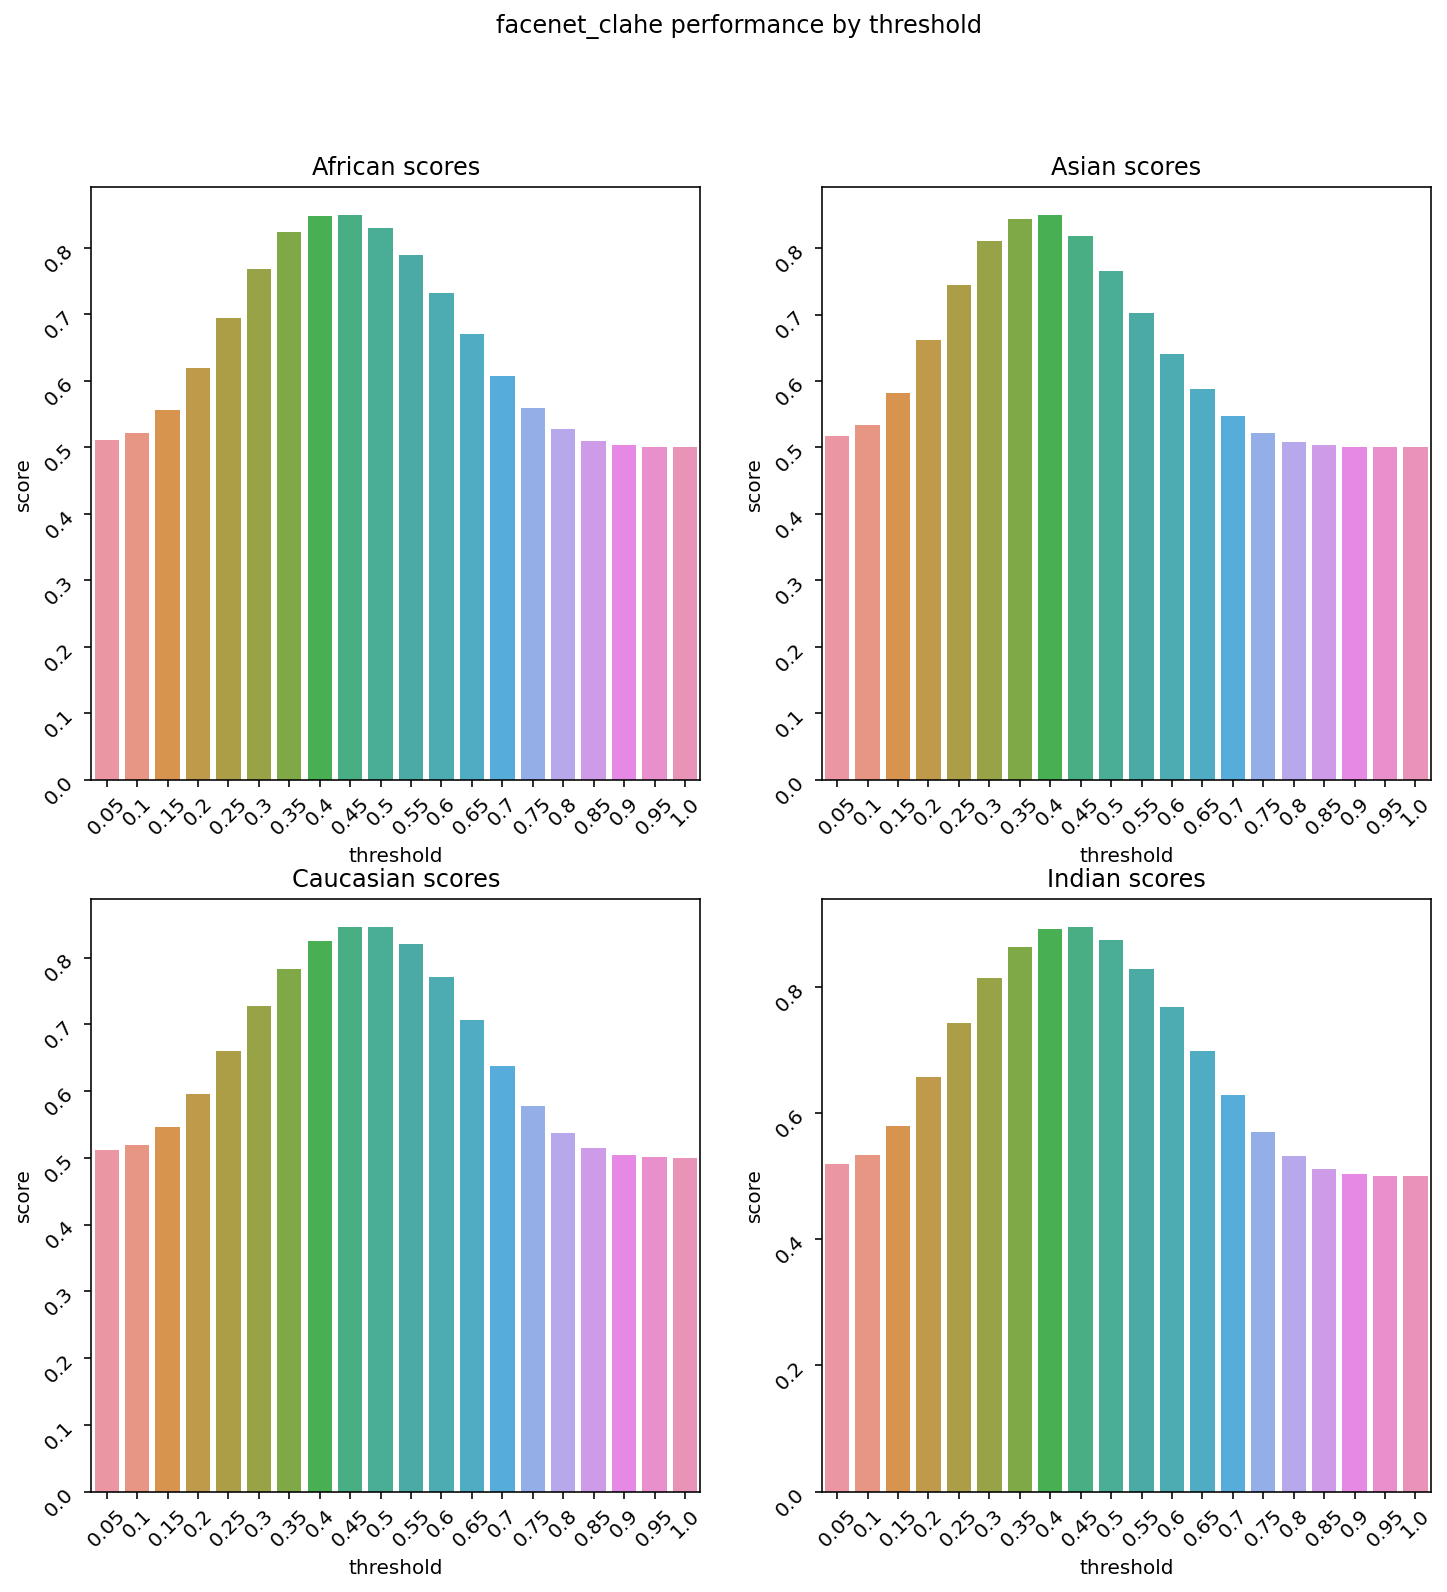

In [11]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [12]:
vgg_face_model = "vgg_face_clahe"


In [13]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.882296,0.881134,0.883459
0,Asian,0.864253,0.862913,0.865593
0,Caucasian,0.819670,0.817977,0.821363
0,African,0.812341,0.810792,0.813889


In [14]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.730027,0.728455,0.731599
0,Caucasian,0.725213,0.723502,0.726924
0,African,0.704303,0.702597,0.706010
0,Asian,0.665097,0.663343,0.666850


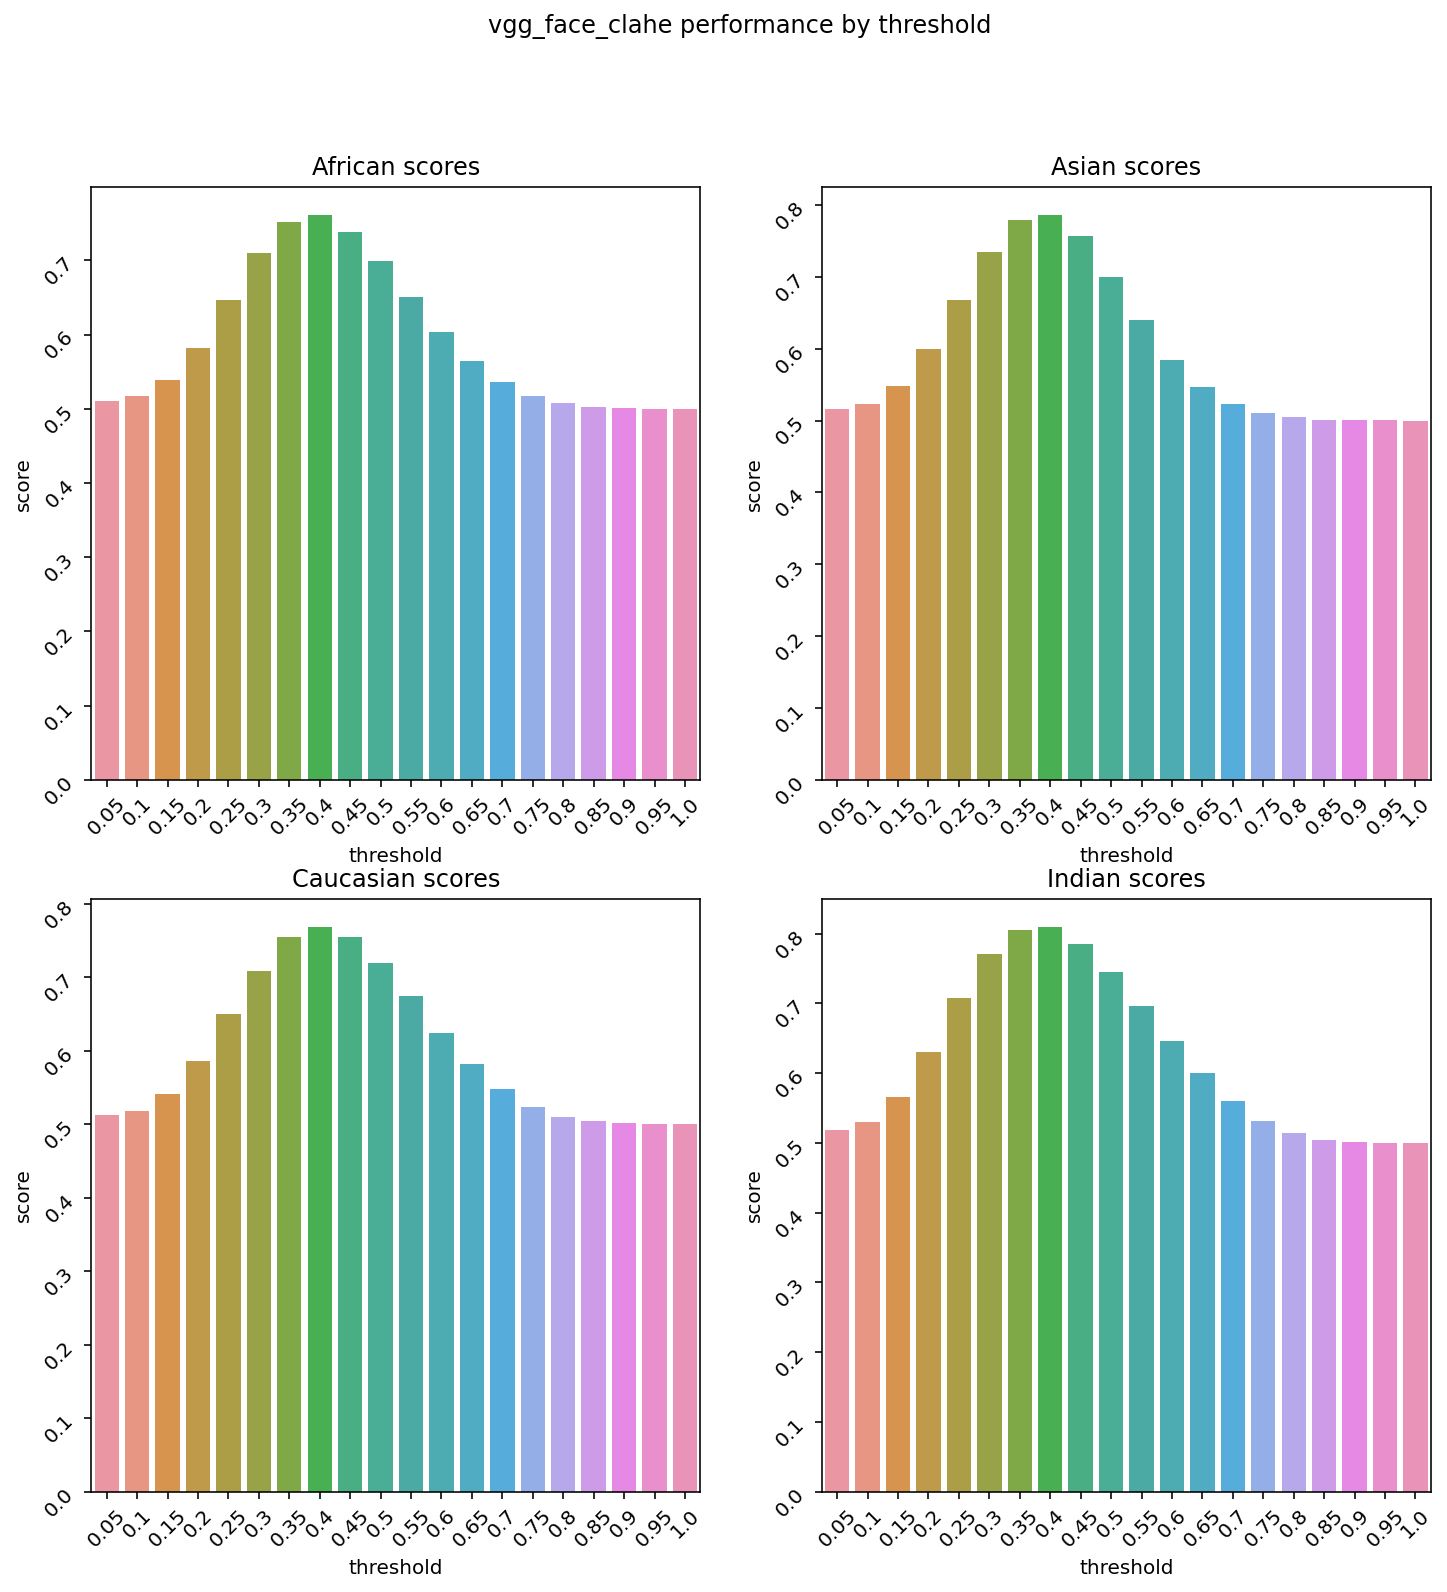

In [15]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [16]:
arcface_model = "arcface_clahe"

In [17]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.832783,0.831275,0.834291
0,Asian,0.799291,0.797768,0.800813
0,Caucasian,0.750104,0.748191,0.752017
0,African,0.734663,0.732952,0.736374


In [18]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.618723,0.616892,0.620554
0,Caucasian,0.610333,0.608560,0.612106
0,Asian,0.595523,0.593837,0.597209
0,African,0.592313,0.590639,0.593988


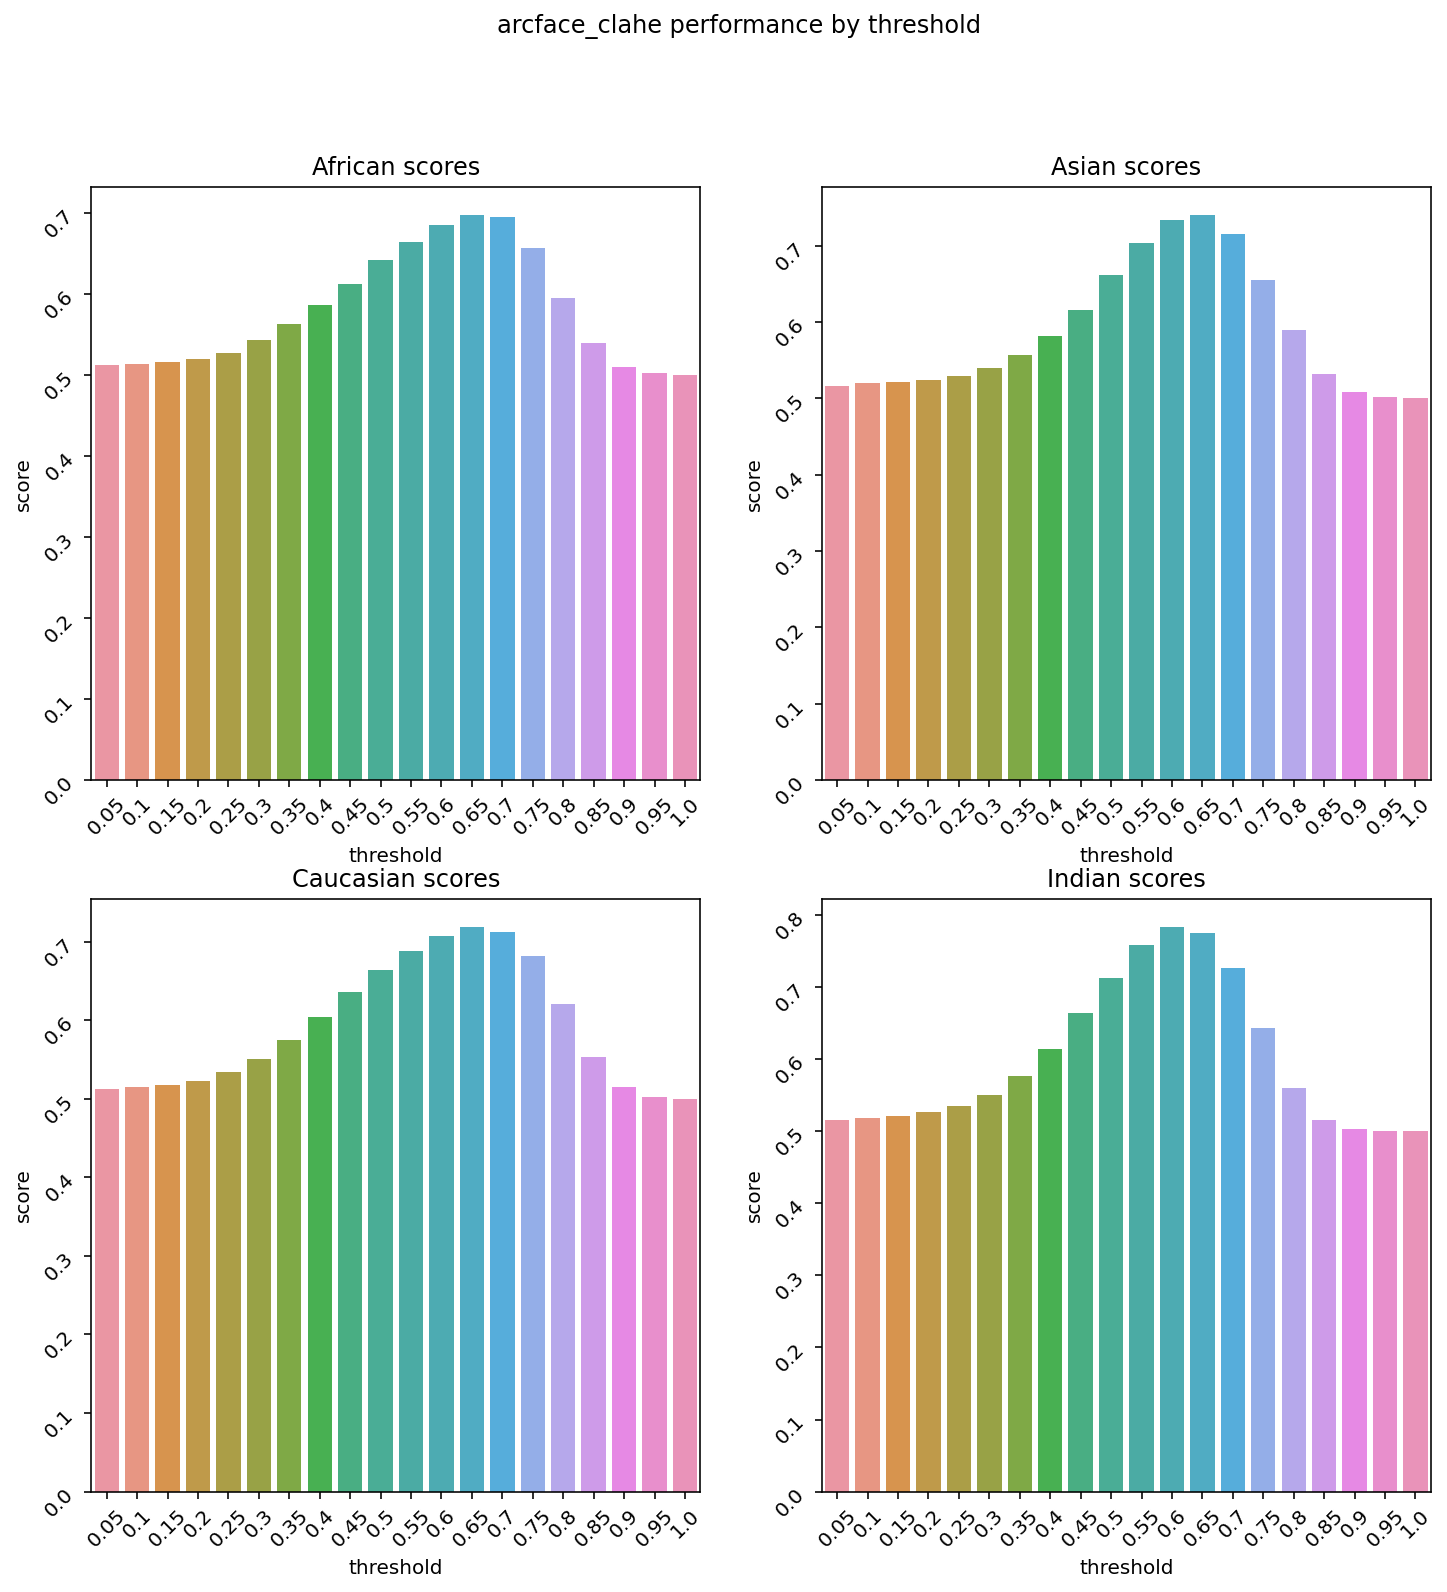

In [19]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

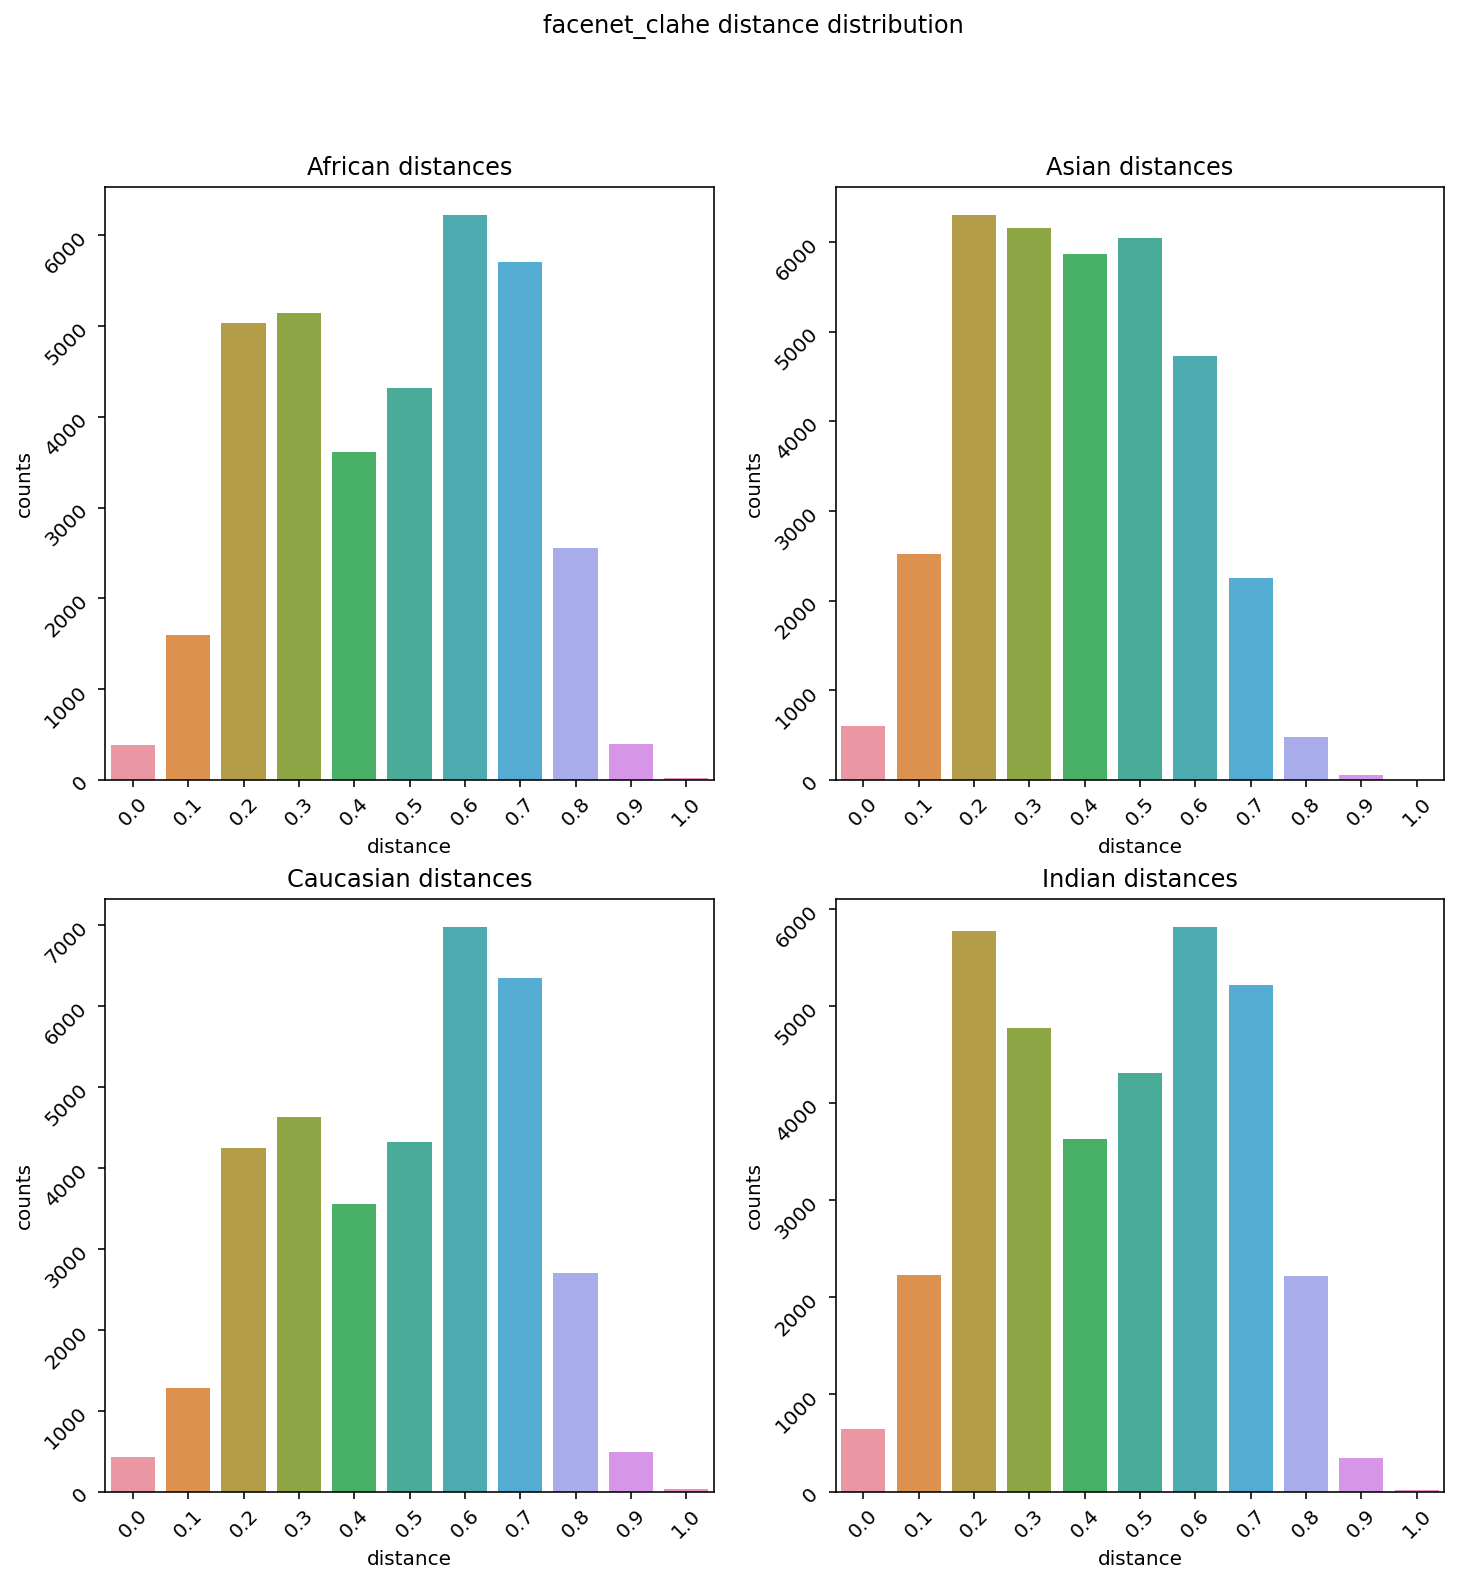

In [20]:
plot_score_distribution(facenet_model)

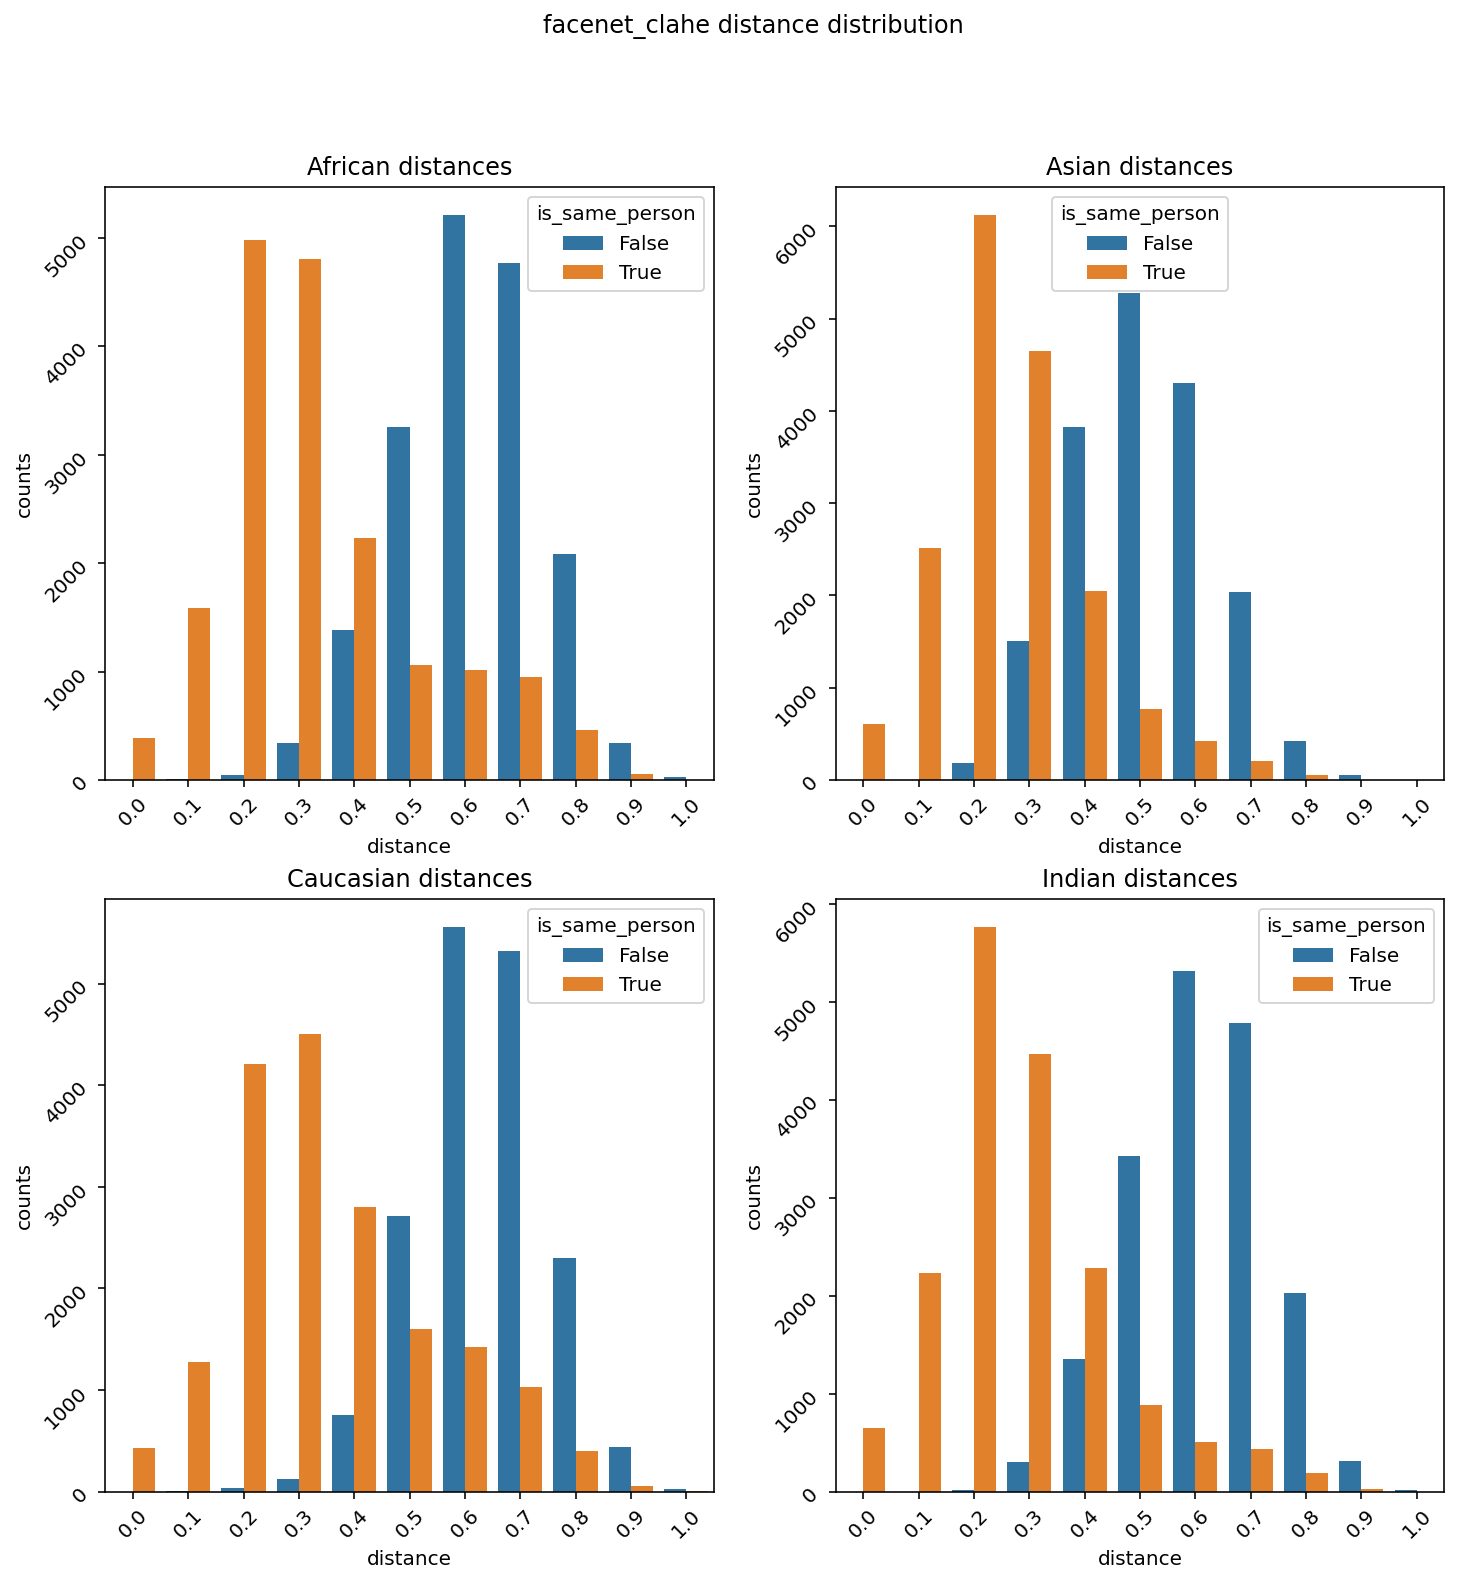

In [21]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [22]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.3596257405562632
African difference in mean: -0.39827402361927566
Caucasian difference in mean: -0.40912008392255467
Indian difference in mean: -0.46444770294817034


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


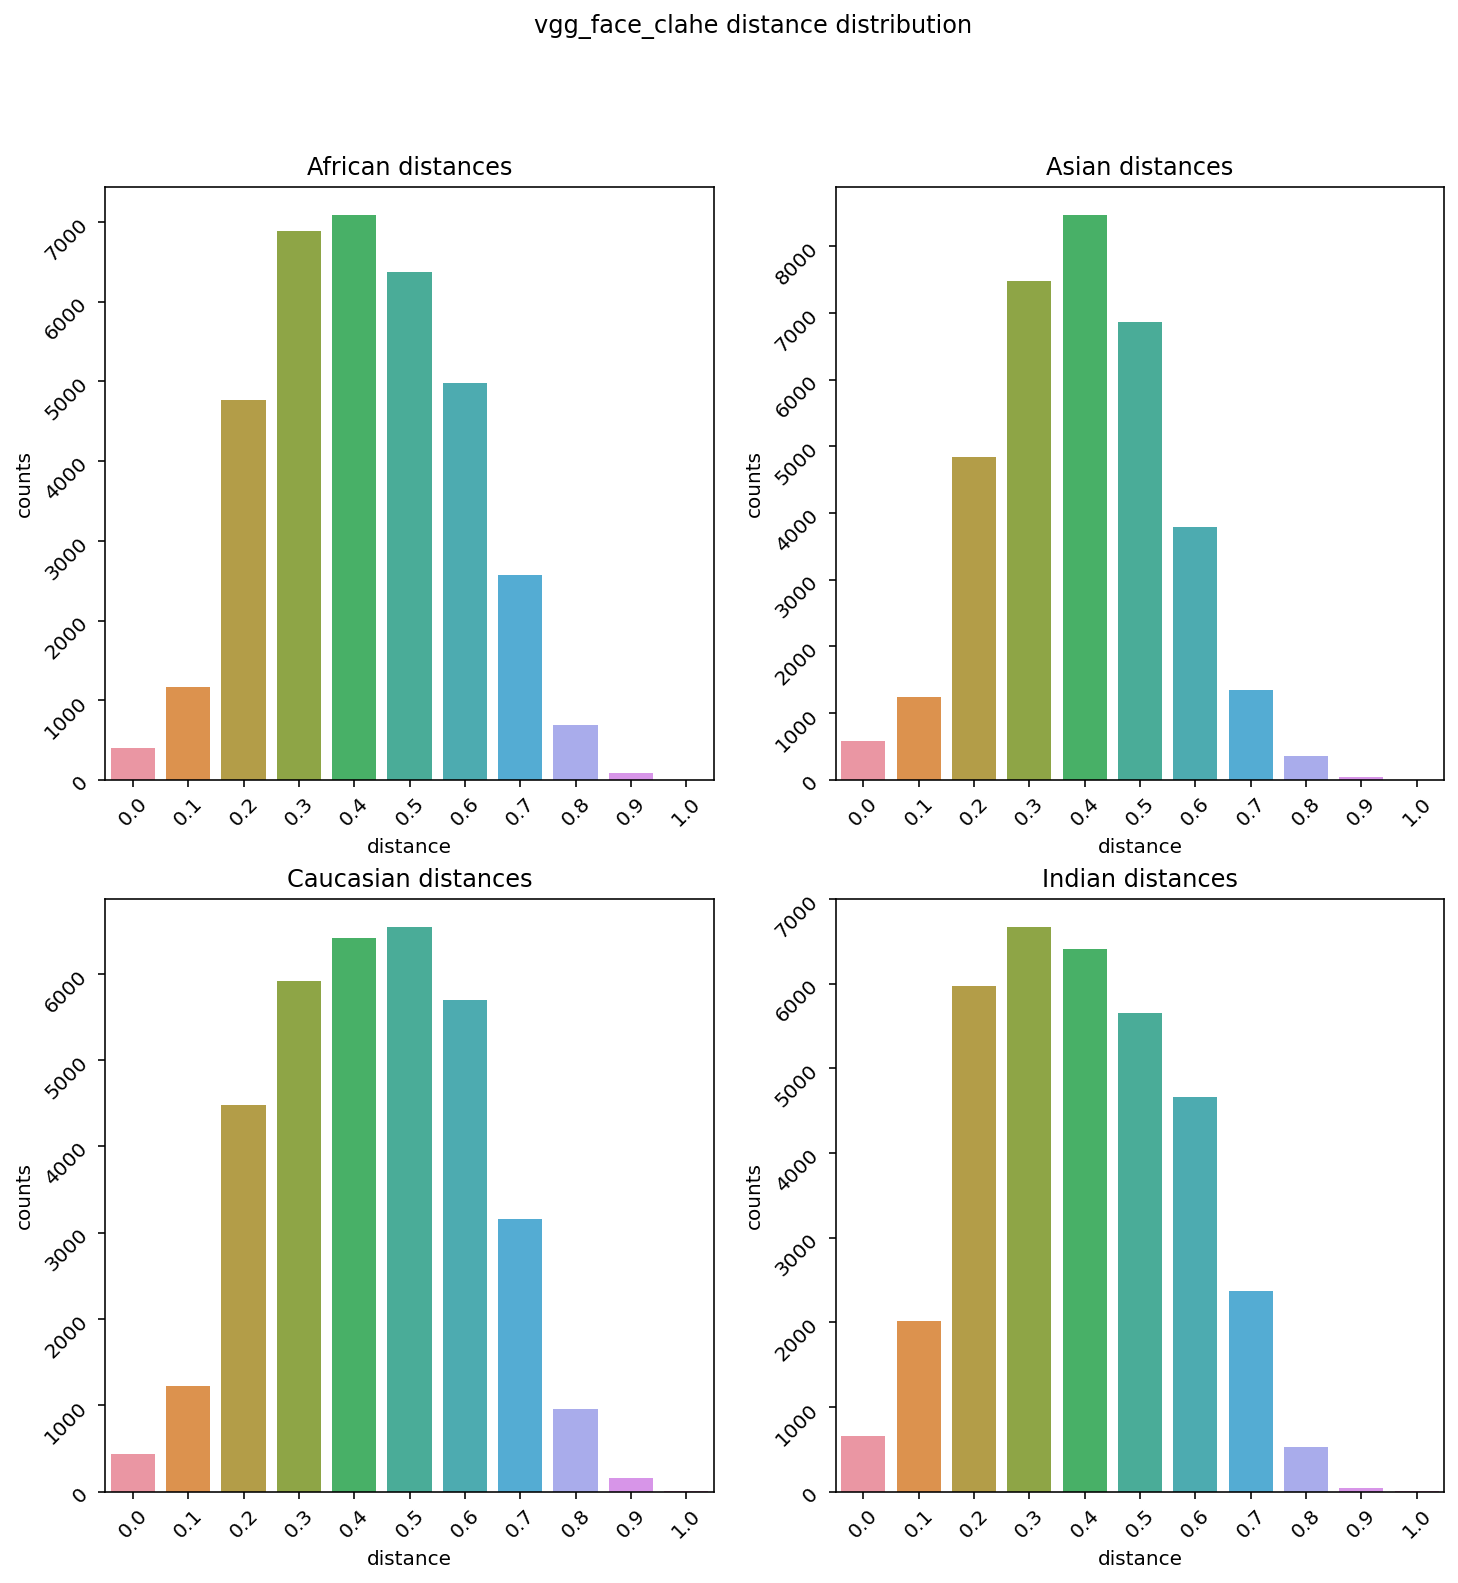

In [23]:
plot_score_distribution(vgg_face_model)

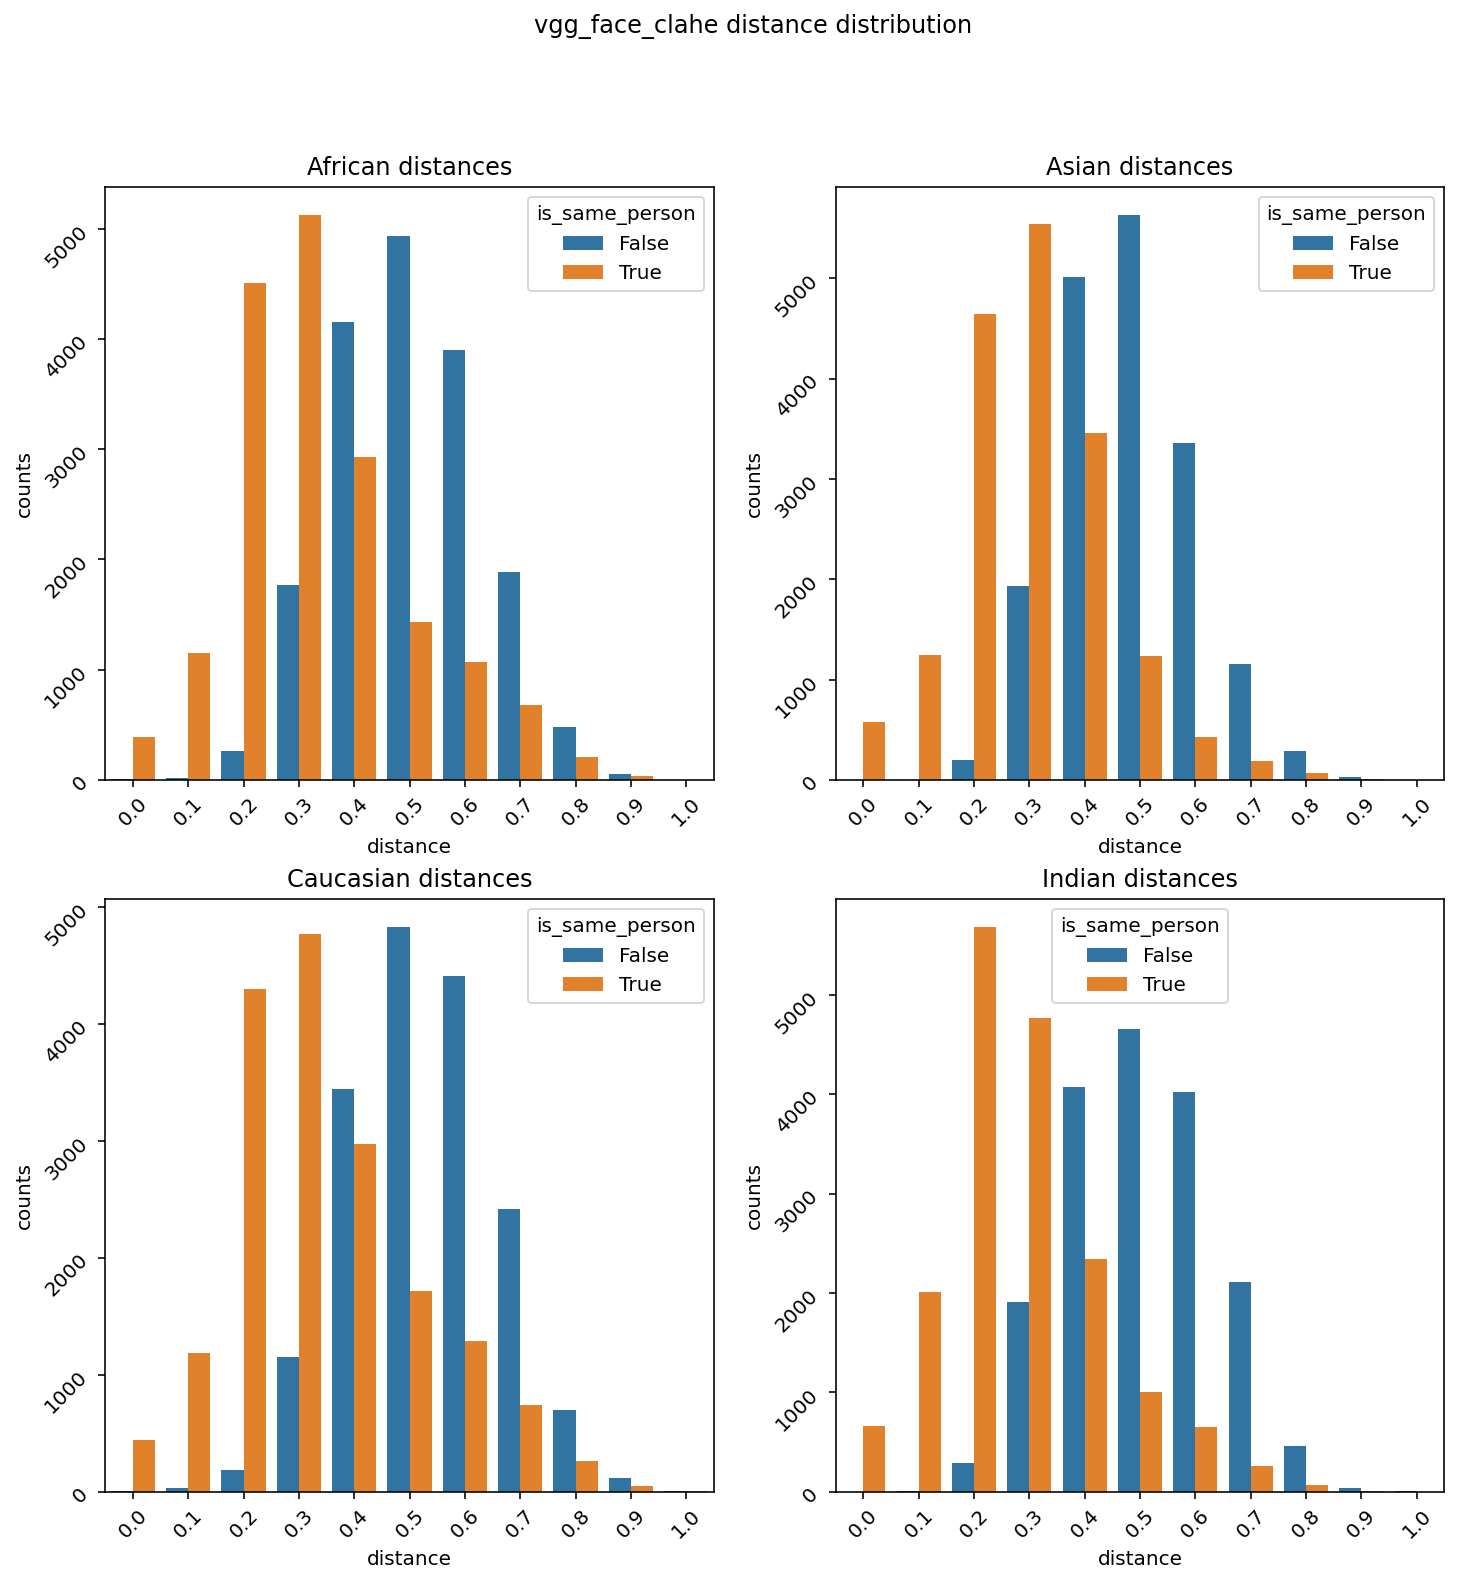

In [24]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [25]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.18225465522831313
African difference in mean: -0.1848424186524324
Caucasian difference in mean: -0.20033682119371427
Indian difference in mean: -0.2349264218594605


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

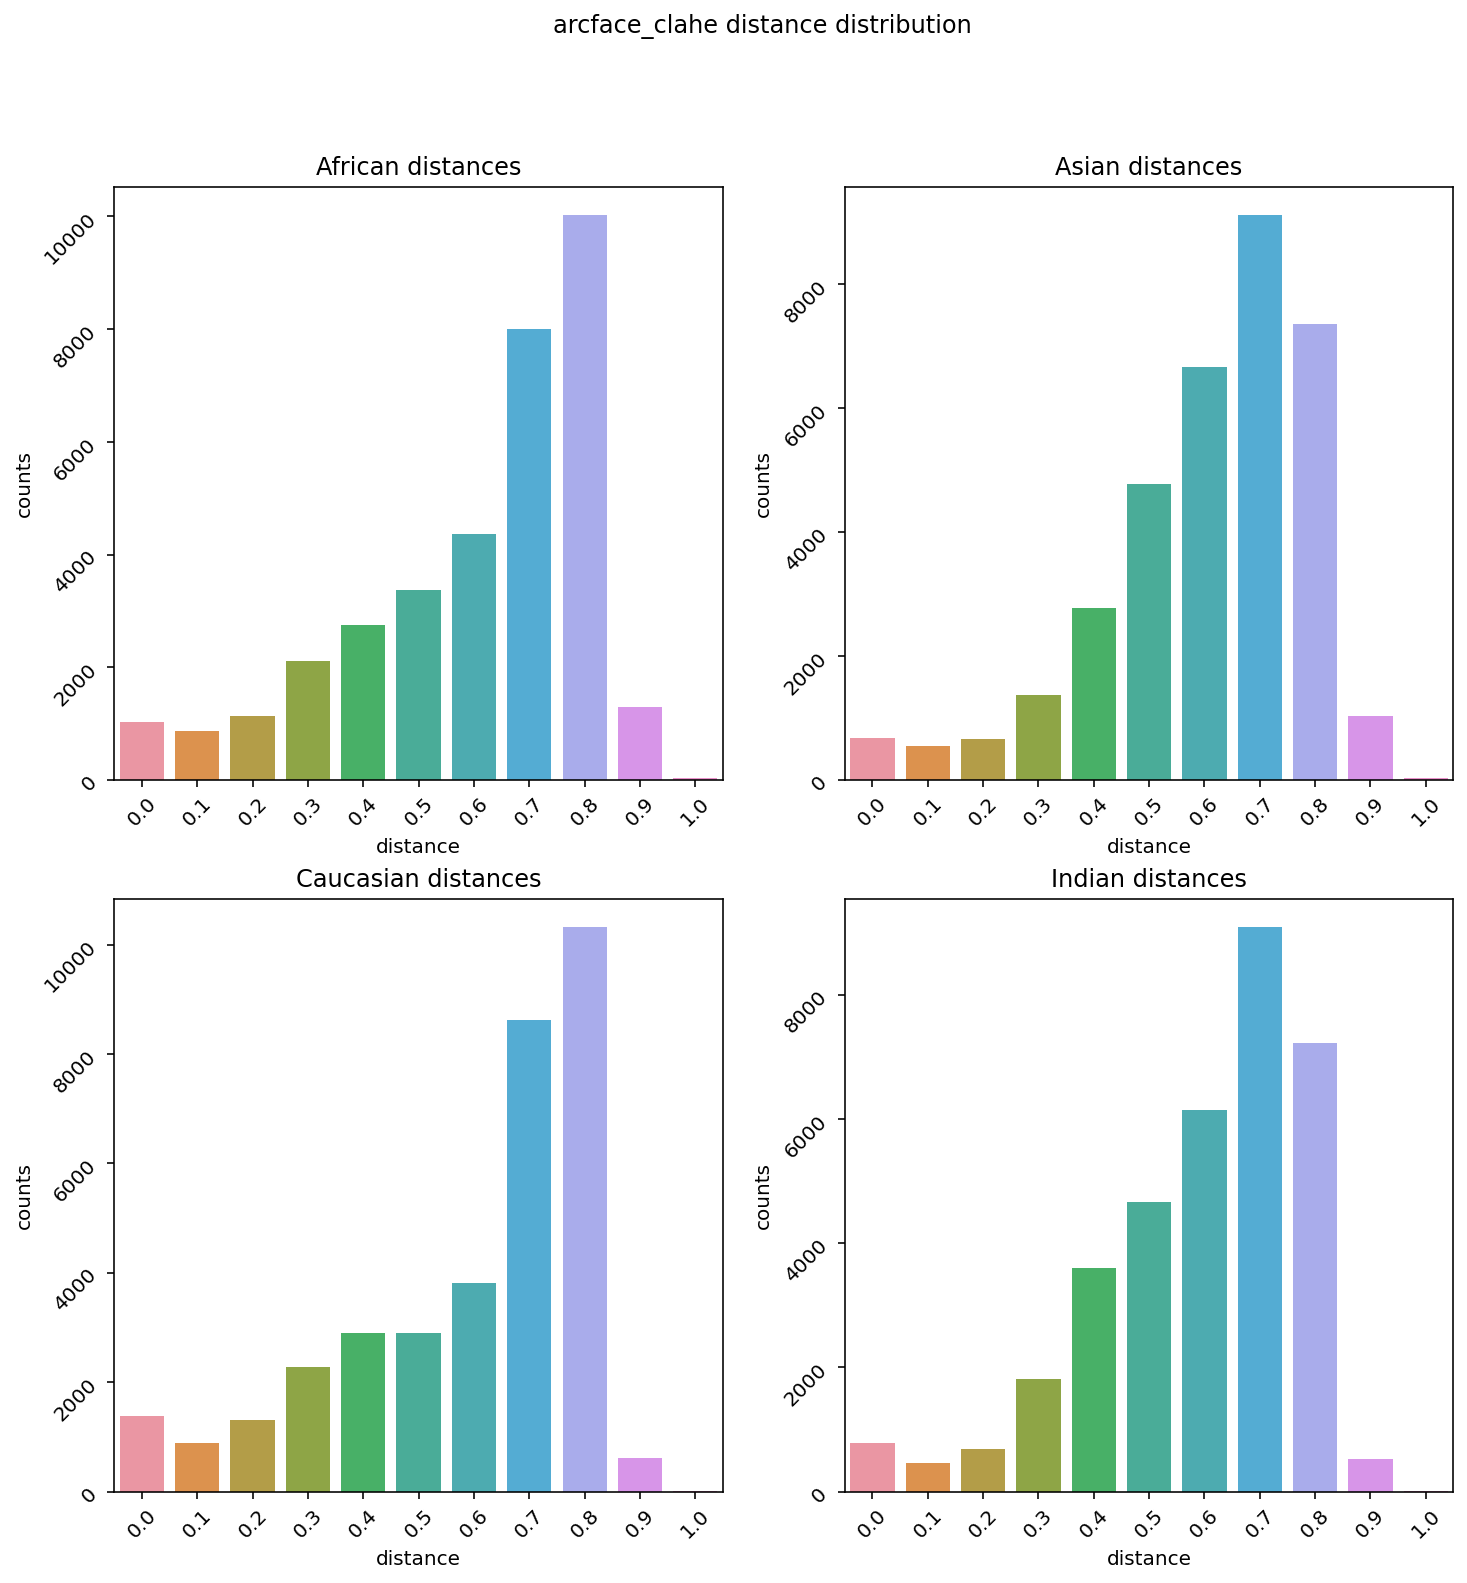

In [26]:
plot_score_distribution(arcface_model)

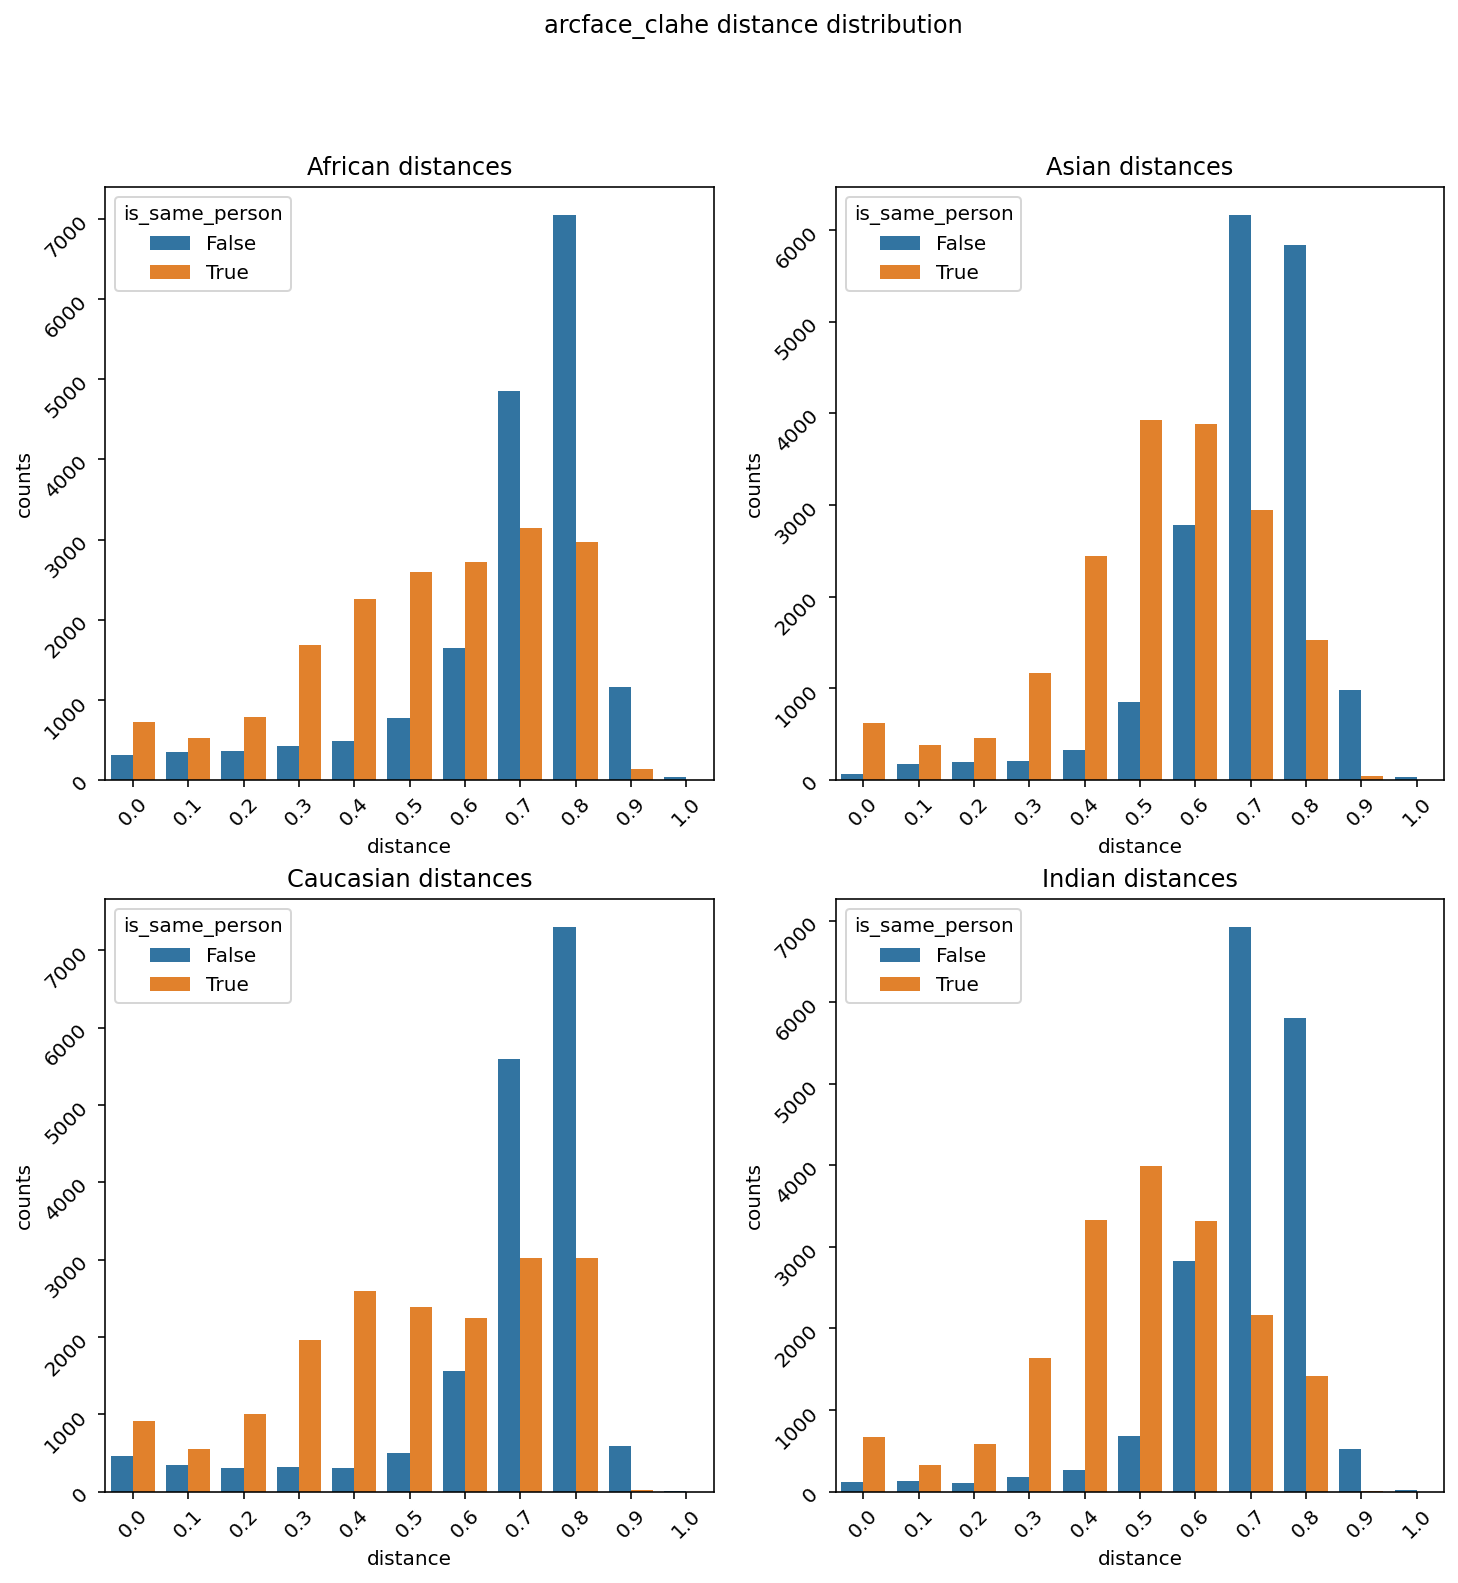

In [27]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [28]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.20908062290459895
African difference in mean: -0.19147850413966516
Caucasian difference in mean: -0.22016289438007375
Indian difference in mean: -0.24948702685454927


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [29]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [30]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [31]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 1.1416837892585461e-34
Wilcoxon test on Asian performance: 6.757978247442735e-27
Wilcoxon test on African performance: 0.9176068968177927
Wilcoxon test on Indian performance: 1.6194864626223344e-07


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [32]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  1.669095022981974e-88
Wilcoxon test on Asian performance:  2.4899514434366993e-11
Wilcoxon test on African performance:  8.250067449613307e-09
Wilcoxon test on Indian performance:  2.9291149337216237e-21


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [33]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  1.5037699143624456e-15
Wilcoxon test on Asian performance:  0.00243624426626073
Wilcoxon test on African performance:  6.098077859928506e-19
Wilcoxon test on Indian performance:  3.070491558167042e-07


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [34]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [35]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = apply_clahe)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = apply_clahe)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = apply_clahe)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = apply_clahe)

In [36]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.3014039797311774
Prediction_local [2.32532786]
Right: 2.8295238
Intercept -0.8659877205436902
Prediction_local [2.25767961]
Right: 3.0182147


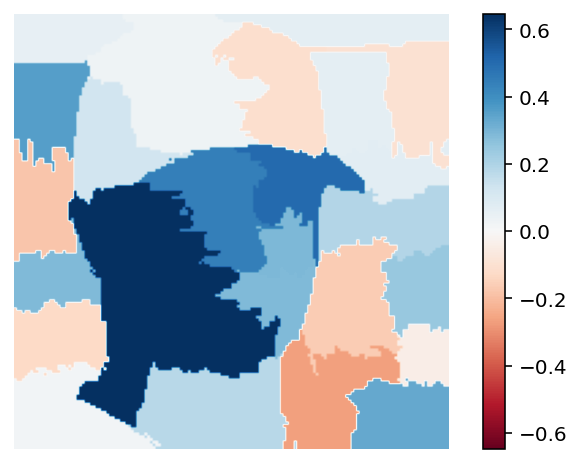

In [37]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.7322187908114628
Prediction_local [2.61238785]
Right: 2.867256
Intercept -3.0632627527978955
Prediction_local [2.62550482]
Right: 3.232591


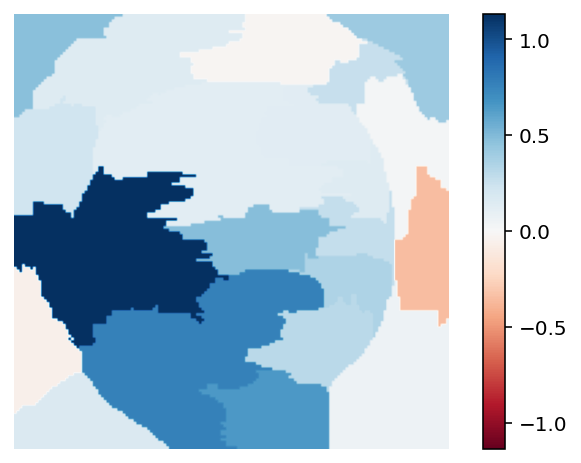

In [38]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -3.0340655911916126
Prediction_local [1.6946081]
Right: 3.0246992
Intercept -2.074438924610131
Prediction_local [2.38728407]
Right: 3.521274


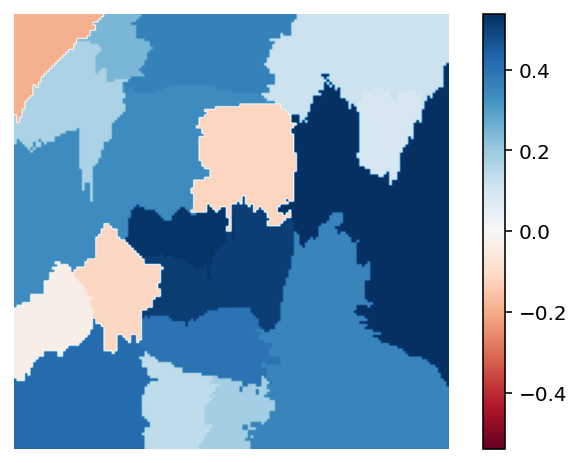

In [39]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -2.6076692177066265
Prediction_local [2.14634266]
Right: 2.3191378
Intercept -0.9187011475317969
Prediction_local [2.04857739]
Right: 2.3581052


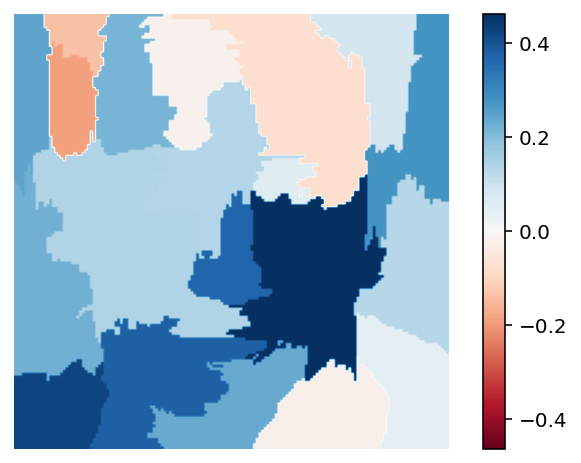

In [40]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [41]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = apply_clahe)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = apply_clahe)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = apply_clahe)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = apply_clahe)

In [42]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.03834826494966509
Prediction_local [0.05644783]
Right: 0.049337927
Intercept 0.04050399184915321
Prediction_local [0.06413671]
Right: 0.062476467


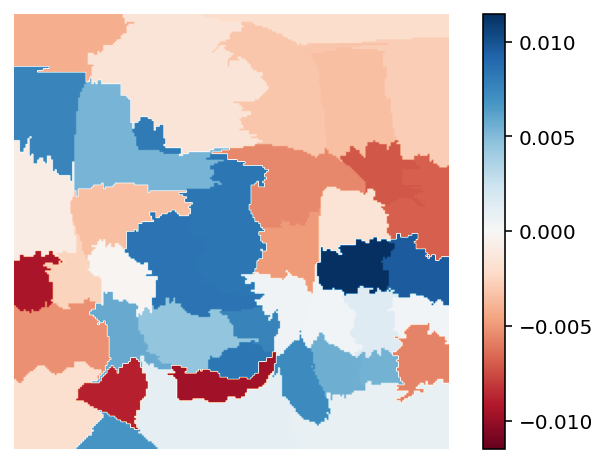

In [43]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.04651717519861648
Prediction_local [0.05381845]
Right: 0.049337927
Intercept 0.04570290864691878
Prediction_local [0.06385519]
Right: 0.062476467


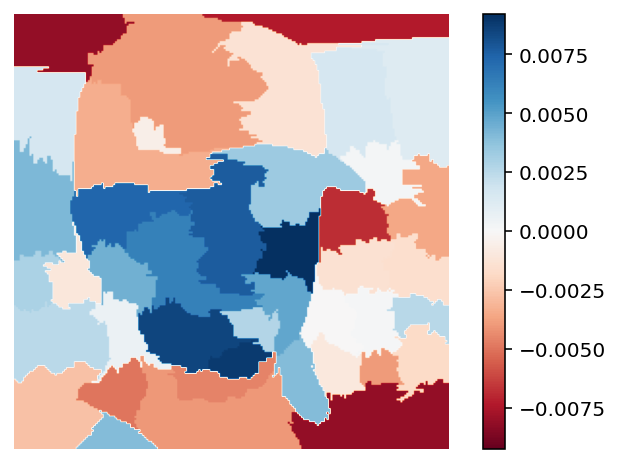

In [44]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.0649053472816067
Prediction_local [0.04207687]
Right: 0.05391837
Intercept 0.026412810304663793
Prediction_local [0.05626475]
Right: 0.0565572


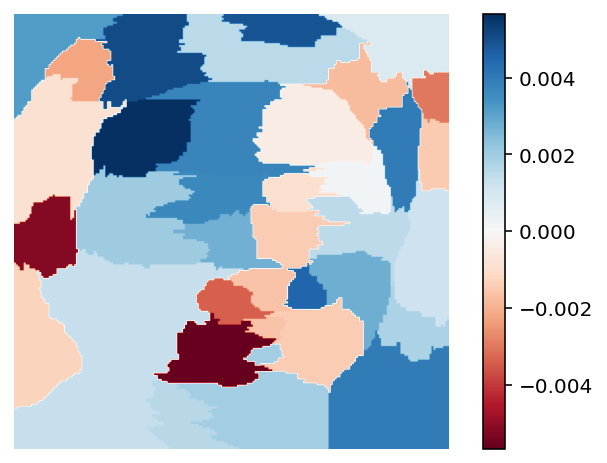

In [45]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.12006118804203919
Prediction_local [0.06612724]
Right: 0.08747238
Intercept -0.07099590517423178
Prediction_local [0.07852757]
Right: 0.09051339


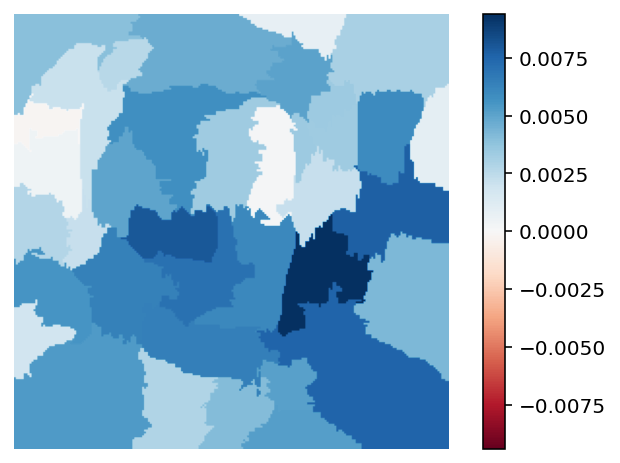

In [46]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.06775183672949413
Prediction_local [0.04813235]
Right: 0.043811075
Intercept -0.03338120342111114
Prediction_local [0.04150251]
Right: 0.04669753


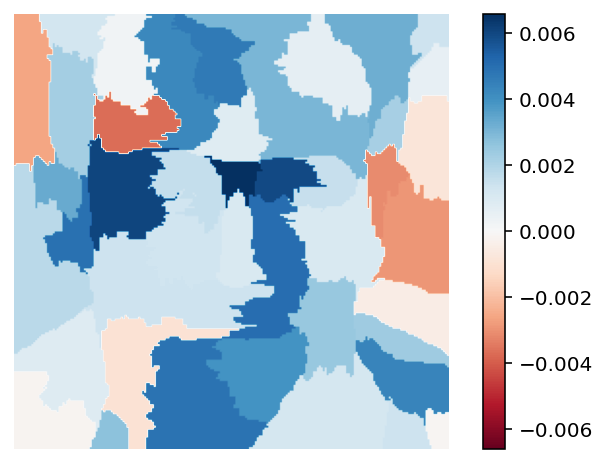

In [47]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [62]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = apply_clahe)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = apply_clahe)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = apply_clahe)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = apply_clahe)

In [49]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -11.879021187061092
Prediction_local [-1.41362415]
Right: 0.30382746
Intercept 9.560259382610687
Prediction_local [2.30844386]
Right: 0.33709407


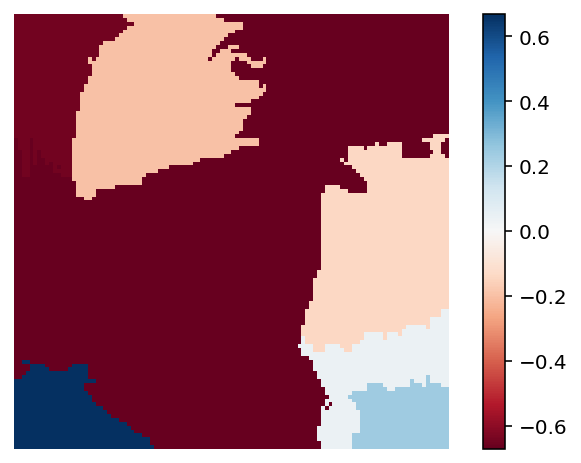

In [50]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -3.066656513493087
Prediction_local [0.86379754]
Right: 0.37033927
Intercept 19.07827393722672
Prediction_local [5.43199977]
Right: 0.42092386


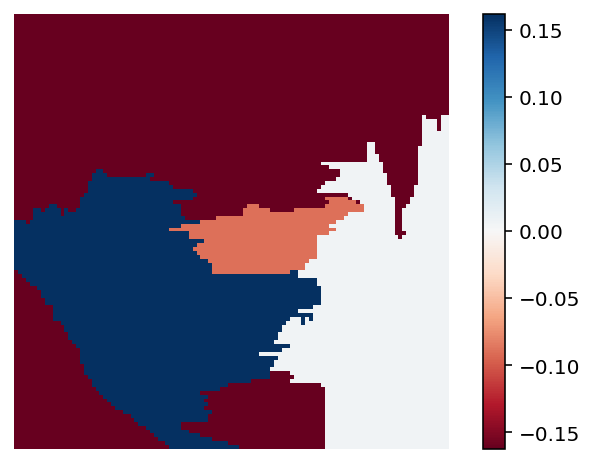

In [69]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1.186918628618273
Prediction_local [1.79382306]
Right: 0.38136876
Intercept -2.4510699890148686
Prediction_local [-0.06284069]
Right: 0.47229266


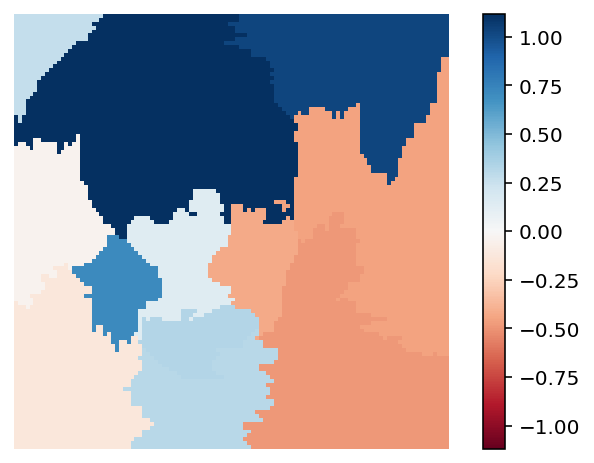

In [65]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -6.219442309518514
Prediction_local [-0.43263599]
Right: 0.44357744
Intercept -0.6837711246270277
Prediction_local [1.07057889]
Right: 0.44392723


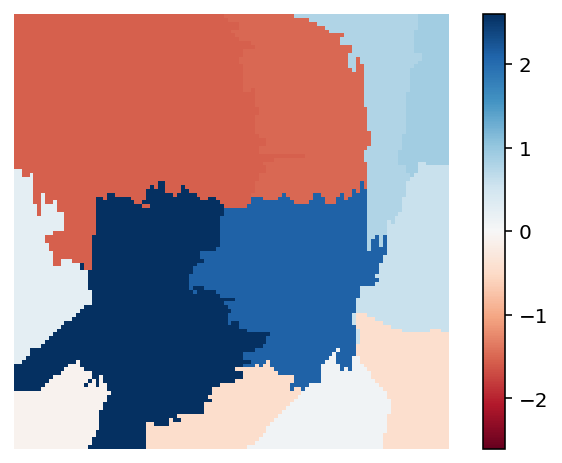

In [53]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others